In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define general attributes
attribute_names = [
    "Age", "Sex", "Height", "Weight", "QRS_duration", "PR_interval", "QT_interval",
    "T_interval", "P_interval", "QRS_angle", "T_angle", "P_angle", "QRST_angle",
    "J_angle", "Heart_rate"
]

# ECG Leads
leads = ["DI", "DII", "DIII", "AVR", "AVL", "AVF", "V1", "V2", "V3", "V4", "V5", "V6"]

# Define width/morphology features (12 features per lead)
width_features = [
    "Q_width", "R_width", "S_width", "R_prime_width", "S_prime_width",
    "Intrinsic_deflections",
    "R_ragged", "R_diphasic", "P_ragged", "P_diphasic", "T_ragged", "T_diphasic"
]

# Define amplitude features (10 features per lead)
amp_features = [
    "JJ_amp", "Q_amp", "R_amp", "S_amp", "R_prime_amp", "S_prime_amp",
    "P_amp", "T_amp", "QRSA", "QRSTA"
]

# Add width/morphology features for all leads
for lead in leads:
    attribute_names.extend([f"{lead}_{feat}" for feat in width_features])

# Add amplitude features for all leads
for lead in leads:
    attribute_names.extend([f"{lead}_{feat}" for feat in amp_features])

# Add class label at the end (280th column)
attribute_names.append("Class")

# Load CSV file (replace 'arrhythmia.csv' with your actual path)
df = pd.read_csv("arrhythmia.csv", header=None, names=attribute_names, na_values="?")

# Show structure of the dataset
print(df.head())
print(f"Shape: {df.shape}")


   Age  Sex  Height  Weight  QRS_duration  PR_interval  QT_interval  \
0   75    0     190      80            91          193          371   
1   56    1     165      64            81          174          401   
2   54    0     172      95           138          163          386   
3   55    0     175      94           100          202          380   
4   75    0     190      80            88          181          360   

   T_interval  P_interval  QRS_angle  ...  V6_Q_amp  V6_R_amp  V6_S_amp  \
0         174         121        -16  ...       0.0       9.0      -0.9   
1         149          39         25  ...       0.0       8.5       0.0   
2         185         102         96  ...       0.0       9.5      -2.4   
3         179         143         28  ...       0.0      12.2      -2.2   
4         177         103        -16  ...       0.0      13.1      -3.6   

   V6_R_prime_amp  V6_S_prime_amp  V6_P_amp  V6_T_amp  V6_QRSA  V6_QRSTA  \
0             0.0             0.0       0.9   

In [ ]:
print(df.columns.tolist())

['Age', 'Sex', 'Height', 'Weight', 'QRS_duration', 'PR_interval', 'QT_interval', 'T_interval', 'P_interval', 'QRS_angle', 'T_angle', 'P_angle', 'QRST_angle', 'J_angle', 'Heart_rate', 'DI_Q_width', 'DI_R_width', 'DI_S_width', 'DI_R_prime_width', 'DI_S_prime_width', 'DI_Intrinsic_deflections', 'DI_R_ragged', 'DI_R_diphasic', 'DI_P_ragged', 'DI_P_diphasic', 'DI_T_ragged', 'DI_T_diphasic', 'DII_Q_width', 'DII_R_width', 'DII_S_width', 'DII_R_prime_width', 'DII_S_prime_width', 'DII_Intrinsic_deflections', 'DII_R_ragged', 'DII_R_diphasic', 'DII_P_ragged', 'DII_P_diphasic', 'DII_T_ragged', 'DII_T_diphasic', 'DIII_Q_width', 'DIII_R_width', 'DIII_S_width', 'DIII_R_prime_width', 'DIII_S_prime_width', 'DIII_Intrinsic_deflections', 'DIII_R_ragged', 'DIII_R_diphasic', 'DIII_P_ragged', 'DIII_P_diphasic', 'DIII_T_ragged', 'DIII_T_diphasic', 'AVR_Q_width', 'AVR_R_width', 'AVR_S_width', 'AVR_R_prime_width', 'AVR_S_prime_width', 'AVR_Intrinsic_deflections', 'AVR_R_ragged', 'AVR_R_diphasic', 'AVR_P_ragged

In [ ]:
df.head(10)

,Age,Sex,Height,Weight,QRS_duration,PR_interval,QT_interval,T_interval,P_interval,QRS_angle,...,V6_Q_amp,V6_R_amp,V6_S_amp,V6_R_prime_amp,V6_S_prime_amp,V6_P_amp,V6_T_amp,V6_QRSA,V6_QRSTA,Class
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0.0,-0.1,3.9,25.4,62.8,7
5,13,0,169,51,100,167,321,174,91,107,...,-0.6,12.2,-2.8,0.0,0.0,0.9,2.2,13.5,31.1,14
6,40,1,160,52,77,129,377,133,77,77,...,0.0,6.5,0.0,0.0,0.0,0.4,1.0,14.3,20.5,1
7,49,1,162,54,78,0,376,157,70,67,...,0.0,8.2,-1.9,0.0,0.0,0.1,0.5,15.8,19.8,1
8,44,0,168,56,84,118,354,160,63,61,...,0.0,7.0,-1.3,0.0,0.0,0.6,2.1,12.5,30.9,1
9,50,1,167,67,89,130,383,156,73,85,...,-0.6,10.8,-1.7,0.0,0.0,0.8,0.9,20.1,25.1,10


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, Age to Class
dtypes: float64(125), int64(155)
memory usage: 988.9 KB


In [ ]:
df.nunique()

,0
Age,77
Sex,2
Height,53
Weight,76
QRS_duration,67
...,...
V6_P_amp,24
V6_T_amp,71
V6_QRSA,286
V6_QRSTA,332


In [ ]:
df.isnull().sum()

,0
Age,0
Sex,0
Height,0
Weight,0
QRS_duration,0
...,...
V6_P_amp,0
V6_T_amp,0
V6_QRSA,0
V6_QRSTA,0


In [ ]:
missing_values = df.isnull().sum()
print(f"missing values:\n", missing_values[missing_values > 0])

missing values:
 T_angle         8
P_angle        22
QRST_angle      1
J_angle       376
Heart_rate      1
dtype: int64


hadling missing values

In [ ]:
missing_cols = list(missing_values[missing_values > 0].index)

for col in missing_cols:
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

/tmp/ipython-input-2616154016.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)


# **ghraps**

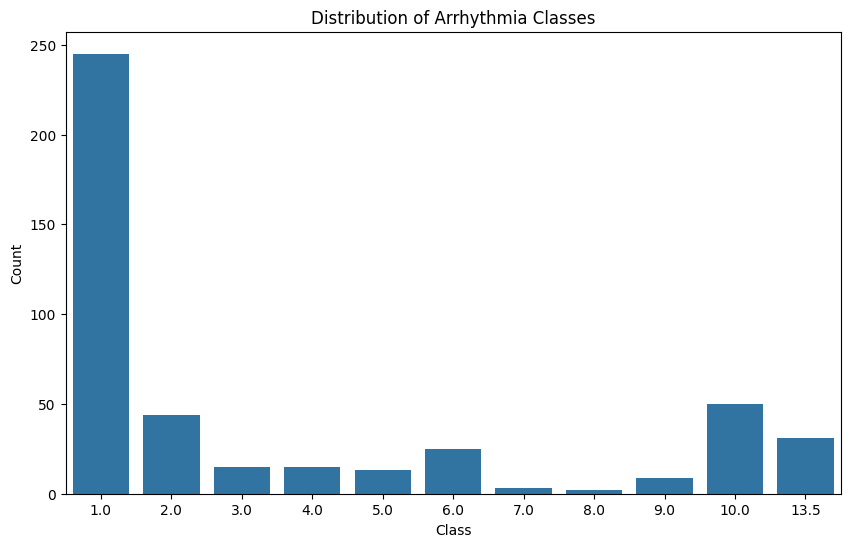

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Class')
plt.title('Distribution of Arrhythmia Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

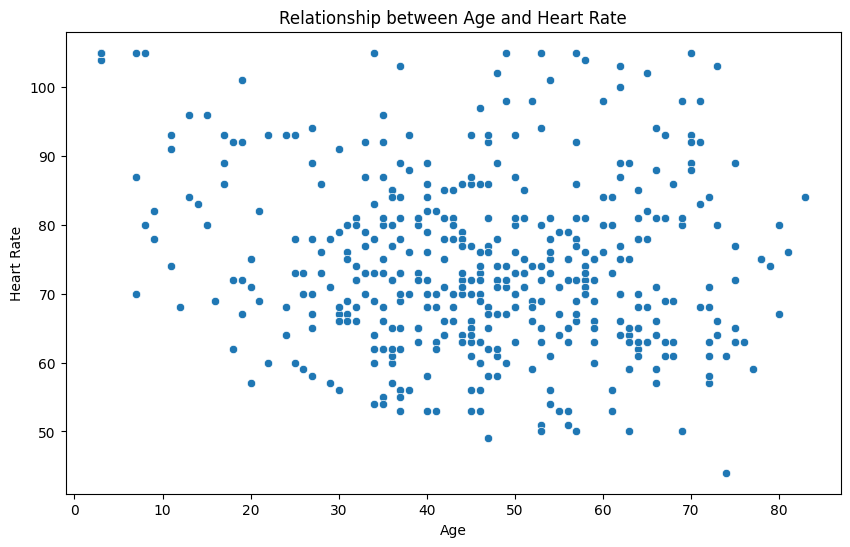

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Age', y='Heart_rate')
plt.title('Relationship between Age and Heart Rate')
plt.xlabel('Age')
plt.ylabel('Heart Rate')
plt.show()

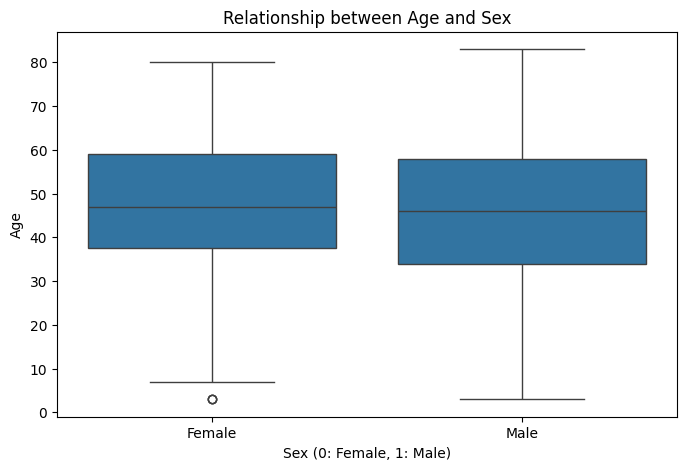

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Sex', y='Age')
plt.title('Relationship between Age and Sex')
plt.xlabel('Sex (0: Female, 1: Male)')
plt.ylabel('Age')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

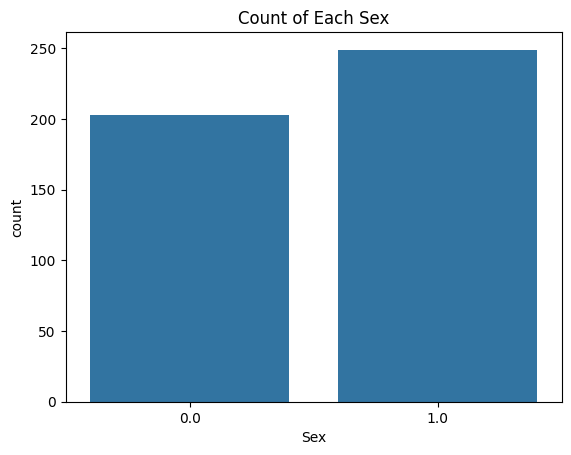

In [ ]:
sns.countplot(x='Sex', data=df)
plt.title("Count of Each Sex")
plt.show()

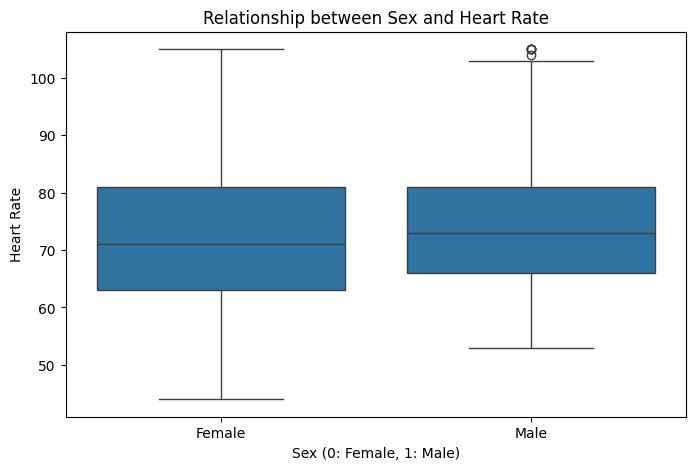

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Sex', y='Heart_rate')
plt.title('Relationship between Sex and Heart Rate')
plt.xlabel('Sex (0: Female, 1: Male)')
plt.ylabel('Heart Rate')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

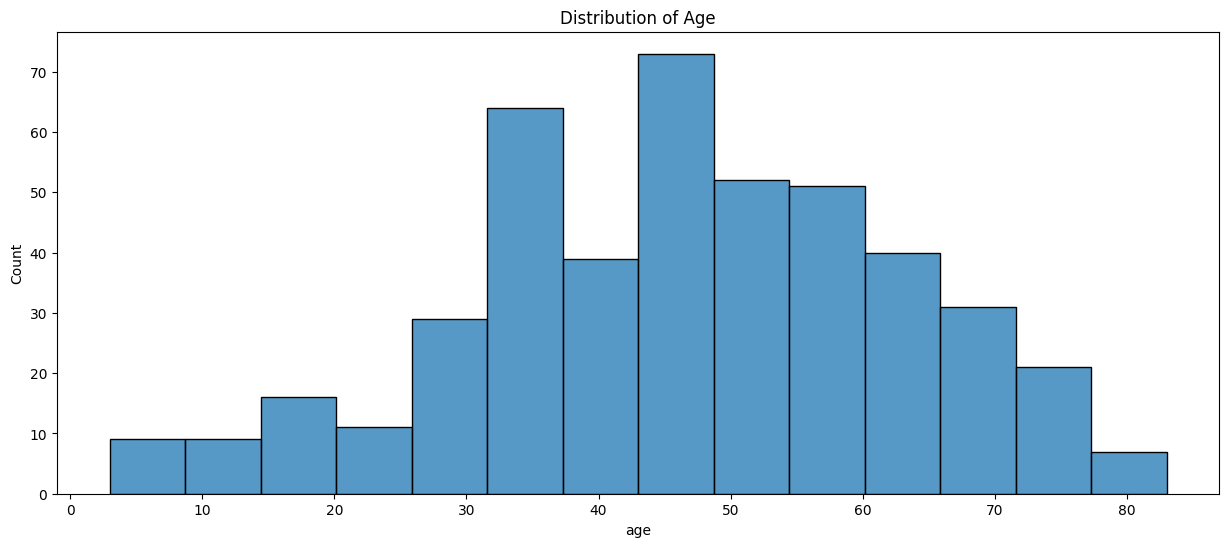

In [ ]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df, x='Age')
plt.title('Distribution of Age')
plt.xlabel('age')
plt.ylabel('Count')
plt.show()

# **data Preprocessing**

In [ ]:
df.describe()

,Age,Sex,Height,Weight,QRS_duration,PR_interval,QT_interval,T_interval,P_interval,QRS_angle,...,V6_Q_amp,V6_R_amp,V6_S_amp,V6_R_prime_amp,V6_S_prime_amp,V6_P_amp,V6_T_amp,V6_QRSA,V6_QRSTA,Class
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.000000,452.000000,452.000000,452.0,452.000000,452.000000,452.000000,452.000000,452.000000
mean,46.471239,0.550885,166.188053,68.170354,88.920354,155.152655,367.207965,169.949115,90.004425,33.676991,...,-0.278982,9.048009,-1.457301,0.003982,0.0,0.514823,1.222345,19.326106,29.473230,3.880531
std,16.466631,0.497955,37.170340,16.590803,15.364394,44.842283,33.385421,35.633072,25.826643,45.431434,...,0.548876,3.472862,2.002430,0.050118,0.0,0.347531,1.426052,13.503922,18.493927,4.407097
min,0.000000,0.000000,105.000000,6.000000,55.000000,0.000000,232.000000,108.000000,0.000000,-172.000000,...,-4.100000,0.000000,-28.600000,0.000000,0.0,-0.800000,-6.000000,-44.200000,-38.600000,1.000000
25%,36.000000,0.000000,160.000000,59.000000,80.000000,142.000000,350.000000,148.000000,79.000000,3.750000,...,-0.425000,6.600000,-2.100000,0.000000,0.0,0.400000,0.500000,11.450000,17.550000,1.000000
50%,47.000000,1.000000,164.000000,68.000000,86.000000,157.000000,367.000000,162.000000,91.000000,40.000000,...,0.000000,8.800000,-1.100000,0.000000,0.0,0.500000,1.350000,18.100000,27.900000,1.000000
75%,58.000000,1.000000,170.000000,79.000000,94.000000,175.000000,384.000000,179.000000,102.000000,66.000000,...,0.000000,11.200000,0.000000,0.000000,0.0,0.700000,2.100000,25.825000,41.125000,6.000000
max,83.000000,1.000000,780.000000,176.000000,188.000000,524.000000,509.000000,381.000000,205.000000,169.000000,...,0.000000,23.600000,0.000000,0.800000,0.0,2.400000,6.000000,88.800000,115.900000,16.000000


capping

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


In [ ]:
df.describe()

,Age,Sex,Height,Weight,QRS_duration,PR_interval,QT_interval,T_interval,P_interval,QRS_angle,...,V6_Q_amp,V6_R_amp,V6_S_amp,V6_R_prime_amp,V6_S_prime_amp,V6_P_amp,V6_T_amp,V6_QRSA,V6_QRSTA,Class
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.00000,452.000000,452.000000,452.000000,452.000000,...,452.000000,452.000000,452.000000,452.0,452.0,452.000000,452.000000,452.000000,452.000000,452.000000
mean,46.486726,0.550885,164.457965,68.247788,87.769912,157.32854,367.634956,167.200221,90.317478,34.262998,...,-0.225636,9.023451,-1.369912,0.0,0.0,0.526217,1.239823,19.209513,29.399558,3.737832
std,16.424450,0.497955,8.474326,15.006890,11.108423,27.14811,29.607737,28.164414,19.444970,43.181979,...,0.363951,3.394280,1.378920,0.0,0.0,0.281278,1.319076,12.005307,17.588693,4.039627
min,3.000000,0.000000,145.000000,29.000000,59.000000,92.50000,299.000000,108.000000,44.500000,-89.625000,...,-1.062500,0.000000,-5.250000,0.0,0.0,-0.050000,-1.900000,-10.112500,-17.812500,1.000000
25%,36.000000,0.000000,160.000000,59.000000,80.000000,142.00000,350.000000,148.000000,79.000000,3.750000,...,-0.425000,6.600000,-2.100000,0.0,0.0,0.400000,0.500000,11.450000,17.550000,1.000000
50%,47.000000,1.000000,164.000000,68.000000,86.000000,157.00000,367.000000,162.000000,91.000000,40.000000,...,0.000000,8.800000,-1.100000,0.0,0.0,0.500000,1.350000,18.100000,27.900000,1.000000
75%,58.000000,1.000000,170.000000,79.000000,94.000000,175.00000,384.000000,179.000000,102.000000,66.000000,...,0.000000,11.200000,0.000000,0.0,0.0,0.700000,2.100000,25.825000,41.125000,6.000000
max,83.000000,1.000000,185.000000,109.000000,115.000000,224.50000,435.000000,225.500000,136.500000,159.375000,...,0.000000,18.100000,0.000000,0.0,0.0,1.150000,4.500000,47.387500,76.487500,13.500000


In [ ]:
df['Class'].value_counts()

,count
Class,
1.0,245
10.0,50
2.0,44
13.5,31
6.0,25
4.0,15
3.0,15
5.0,13
9.0,9


In [ ]:
df['Sex'].dtype

dtype('float64')

scaling

In [ ]:
x = df.drop('Class', axis=1)
sex_col = x['Sex'].copy()
x = x.drop('Sex', axis=1)
y = df['Class']

numerical_cols = x.select_dtypes(include=['int64', 'float64']).columns

scaling = StandardScaler()
scaling.fit(x[numerical_cols])
x[numerical_cols] = scaling.transform(x[numerical_cols])

x['Sex'] = sex_col.loc[x.index]

x_processed_df = x[numerical_cols.tolist() + ['Sex']].copy()

display(x_processed_df.head())

/tmp/ipython-input-1264654730.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x['Sex'] = sex_col.loc[x.index]


,Age,Height,Weight,QRS_duration,PR_interval,QT_interval,T_interval,P_interval,QRS_angle,T_angle,...,V6_Q_amp,V6_R_amp,V6_S_amp,V6_R_prime_amp,V6_S_prime_amp,V6_P_amp,V6_T_amp,V6_QRSA,V6_QRSTA,Sex
0,1.737950,2.426718,0.783989,0.291101,1.315413,0.113780,0.241699,1.579664,-1.165271,-0.594018,...,0.620649,-0.006917,0.341160,0.0,0.0,1.330348,1.259985,0.341101,1.138379,0.0
1,0.579856,0.064033,-0.283369,-0.610115,0.614773,1.128152,-0.646929,-2.358875,-0.214748,-0.055185,...,0.620649,-0.154387,0.994568,0.0,0.0,-1.161053,0.652828,0.099273,0.535052,1.0
2,0.457951,0.890973,1.784637,2.454017,0.209140,0.620966,0.632696,0.601465,1.431278,-0.122539,...,0.620649,0.140553,-0.747853,0.0,0.0,-0.805138,1.639458,-0.576176,1.115612,0.0
3,0.518904,1.245375,1.717927,1.102194,1.647295,0.418092,0.419425,2.377669,-0.145198,-0.638921,...,0.620649,0.936891,-0.602651,0.0,0.0,-0.449224,1.032301,1.283394,1.832775,0.0
4,1.737950,2.426718,0.783989,0.020736,0.872904,-0.258156,0.348335,0.652949,-1.165271,-0.594018,...,0.620649,1.202336,-1.619064,0.0,0.0,-2.050839,2.018931,0.516217,1.901076,0.0


SMOTE

In [ ]:
# Convert 'Class' column to integer type
y = y.astype(int)

# Get the value counts of the classes
class_counts = y.value_counts()

# Identify classes with less than 6 samples (n_neighbors + 1)
classes_to_remove = class_counts[class_counts < 6].index

# Remove rows with classes to remove from both x and y
x_processed_df = x_processed_df[~y.isin(classes_to_remove)]
y = y[~y.isin(classes_to_remove)]


smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_processed_df, y)

print("Shape before SMOTE:", x_processed_df.shape)
print("Shape after SMOTE:", x_resampled.shape)

Shape before SMOTE: (447, 279)
Shape after SMOTE: (2205, 279)

Class distribution before SMOTE:
 Class
1     245
10     50
2      44
13     31
6      25
3      15
4      15
5      13
9       9
Name: count, dtype: int64

Class distribution after SMOTE:
 Class
6     245
10    245
1     245
13    245
3     245
2     245
4     245
5     245
9     245
Name: count, dtype: int64


# **Feature selection**

In [ ]:
pca = PCA(n_components=0.95, random_state=42)

x_pca = pca.fit_transform(x_resampled)

print("Shape of X before PCA:", x_resampled.shape)
print("Shape of X after PCA:", x_pca.shape)

Shape of X before PCA: (2205, 279)
Shape of X after PCA: (2205, 45)


In [ ]:
y_resampled

,Class
0,6
1,10
2,1
3,13
4,1
...,...
2200,13
2201,13
2202,13
2203,13


# **Training**

Random forest


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_pca, y_resampled, test_size=0.2, random_state=42)

RF_model = RandomForestClassifier(random_state=42)
RF_model.fit(X_train, y_train)
RF_model_predictions = RF_model.predict(X_test)

accuracy = accuracy_score(y_test,RF_model_predictions)
precision = precision_score(y_test, RF_model_predictions, average='weighted')
recall = recall_score(y_test, RF_model_predictions, average='weighted')
f1 = f1_score(y_test, RF_model_predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9727891156462585
Precision: 0.9726524797953369
Recall: 0.9727891156462585
F1 Score: 0.9719995024096864


Logistic Regression

In [ ]:
LR_model = LogisticRegression(random_state=42)
LR_model.fit(X_train, y_train)
LR_model_predictions = LR_model.predict(X_test)

accuracy = accuracy_score(y_test, LR_model_predictions)
print("Accuracy:", accuracy)
precision = precision_score(y_test, LR_model_predictions, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, LR_model_predictions, average='weighted')
print("Recall:", recall)
f1 = f1_score(y_test, LR_model_predictions, average='weighted')
print("F1 Score:", f1)

Accuracy: 0.9183673469387755
Precision: 0.915177597409612
Recall: 0.9183673469387755
F1 Score: 0.9159969783826455


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Decision Tree Classifier

In [ ]:
DT_model = DecisionTreeClassifier(random_state=42)
DT_model.fit(X_train, y_train)
DT_model_predictions = DT_model.predict(X_test)

accuracy = accuracy_score(y_test, DT_model_predictions)
print("Accuracy:", accuracy)
precision=precision_score(y_test, DT_model_predictions, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, DT_model_predictions, average='weighted')
print("Recall:", recall)
f1 = f1_score(y_test, DT_model_predictions, average='weighted')
print("F1 Score:", f1)

Accuracy: 0.854875283446712
Precision: 0.8522024675950713
Recall: 0.854875283446712
F1 Score: 0.8529723733369695


Support Vector Classifier (SVC)

In [ ]:
SVM_model = SVC(random_state=42)
SVM_model.fit(X_train, y_train)
SVM_model_predictions = SVM_model.predict(X_test)

accuracy = accuracy_score(y_test, SVM_model_predictions)
print("Accuracy:", accuracy)
precision = precision_score(y_test, SVM_model_predictions, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, SVM_model_predictions, average='weighted')
print("Recall:", recall)
f1 = f1_score(y_test, SVM_model_predictions, average='weighted')
print("F1 Score:", f1)

Accuracy: 0.963718820861678
Precision: 0.9631738867844929
Recall: 0.963718820861678
F1 Score: 0.9628712266637002


K-Nearest Neighbors (KNN) Classifier

In [ ]:
K_NN_model = KNeighborsClassifier()
K_NN_model.fit(X_train, y_train)
K_NN_model_predictions = K_NN_model.predict(X_test)

accuracy = accuracy_score(y_test, K_NN_model_predictions)
print("Accuracy:", accuracy)
precision = precision_score(y_test, K_NN_model_predictions, average='weighted')
print("Precision:", precision)
recall = recall_score(y_test, K_NN_model_predictions, average='weighted')
print("Recall:", recall)
f1 = f1_score(y_test, K_NN_model_predictions, average='weighted')
print("F1 Score:", f1)

Accuracy: 0.9319727891156463
Precision: 0.940763741617194
Recall: 0.9319727891156463
F1 Score: 0.919371008433741
